# Task 2: RNN application -- Tweet Sentiment Analysis

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pickle
import collections
import math
# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

### Load data

In [2]:
with open("./tweets_data/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

# load our data and separate it into tweets and labels
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
train_tweets = np.array([t[0] for t in train_data])
train_labels = np.array([int(t[1]) for t in train_data])

test_data = json.load(open('tweets_data/testTweets_preprocessed.json', 'r'))
test_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),test_data))
test_tweets = np.array([t[0] for t in test_data])
test_labels = np.array([int(t[1]) for t in test_data])

print("size of original train set: {}".format(len(train_tweets)))
print("size of original test set: {}".format(len(test_tweets)))

# only select first 1000 test sample for test
test_tweets = test_tweets[:1000]
test_labels = test_labels[:1000]

print("*"*100)
print("size of train set: {}, #positive: {}, #negative: {}".format(len(train_tweets), np.sum(train_labels), len(train_tweets)-np.sum(train_labels)))
print("size of test set: {}, #positive: {}, #negative: {}".format(len(test_tweets), np.sum(test_labels), len(test_tweets)-np.sum(test_labels)))

# show text of the idx-th train tweet
# The 'padtoken' is used to ensure each tweet has the same length
idx = 100
train_text = [vocabulary[x] for x in train_tweets[idx]]
print(train_text)
sentiment_label = ["negative", "positive"]
print("sentiment: {}".format(sentiment_label[train_labels[idx]]))

size of original train set: 60000
size of original test set: 20000
****************************************************************************************************
size of train set: 60000, #positive: 30055, #negative: 29945
size of test set: 1000, #positive: 510, #negative: 490
['it', 'will', 'help', 'relieve', 'your', 'stress', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken']
sentiment: positive


## Part 1: LSTM Encoder

### train a single-layer lstm network

First of all, we'll build a single-layer LSTM network for the analysis. The network structure is the following:

![](./img/singleLSTM.png)

<span style="color:red">__TODO:__</span> Below, we've defined the network for you. Please read the code carefully to make sure you understand it. Then, please write a training function to train this network. The settings are:

1. Train the network for 1000 iterations. In each iteration, use batch_size samples to train the network.
2. For every 50 iterations, apply the network on the test set, and print out the test accuracy and mean loss.

With these settings, what accuracy could you get? You can try to change some stuff in the network to see if you could get a better accuracy (this is optional).

In [3]:
# define a linear layer, y = x*w + b
def linear(input_, output_size, name, init_bias=0.0):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(name):
        init = tf.truncated_normal([shape[-1], output_size], mean=0.0, stddev=1.0 / shape[-1]**0.5)
        W = tf.get_variable("weight", initializer=init)
    if init_bias is None:
        return tf.matmul(input_, W)
    with tf.variable_scope(name):
        b = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(init_bias))
    return tf.matmul(input_, W) + b

In [4]:
# set variables
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
# init_state = lstm_cell.zero_state(batch_size, tf.float32)
init_state=None
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, initial_state=init_state, dtype=tf.float32)

# print(final_state[-1].get_shape())
# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
print(sentiment)
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

Tensor("Squeeze:0", shape=(?,), dtype=float32)


In [5]:
# Training function
num_steps = 1000
accuracies=[]
numBatches=int(train_tweets.shape[0]/batch_size)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        # TODO: get data for a batch
        
        lowInd= (step % numBatches) * batch_size
        highInd=lowInd + batch_size

        batch_tweets = train_tweets[lowInd : highInd]
#         print(batch_tweets.shape)
        batch_labels = train_labels[lowInd : highInd]

        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer, loss, acc], feed_dict={tweets: batch_tweets, labels: batch_labels})
        
        print('{}/{} loss: {}'.format(
                    batch_size * (step + 1),
                    train_tweets.shape[0],
                    train_loss))
#         print(train_acc)
        
#         _, train_loss, train_acc = pass

        if (step % 50 == 0):
            accuracy=sess.run([acc], feed_dict={tweets: test_tweets, labels: test_labels})
            print('test accuracy - ', accuracy)
            accuracies.append(accuracy)
#             TODO: get test accuracy and loss, and print them out.
            

64/60000 loss: 0.6923321485519409
test accuracy -  [0.546]
128/60000 loss: 0.6934406757354736
192/60000 loss: 0.6931580305099487
256/60000 loss: 0.6913443803787231
320/60000 loss: 0.6935900449752808
384/60000 loss: 0.6921401023864746
448/60000 loss: 0.6915270090103149
512/60000 loss: 0.6933114528656006
576/60000 loss: 0.6949700117111206
640/60000 loss: 0.6922363042831421
704/60000 loss: 0.6934197545051575
768/60000 loss: 0.6910769939422607
832/60000 loss: 0.696488618850708
896/60000 loss: 0.6933280229568481
960/60000 loss: 0.6954222321510315
1024/60000 loss: 0.6895605325698853
1088/60000 loss: 0.6886603832244873
1152/60000 loss: 0.6944583058357239
1216/60000 loss: 0.6908156871795654
1280/60000 loss: 0.6963595151901245
1344/60000 loss: 0.692743182182312
1408/60000 loss: 0.6924545764923096
1472/60000 loss: 0.6934477686882019
1536/60000 loss: 0.6860648989677429
1600/60000 loss: 0.691290557384491
1664/60000 loss: 0.6896940469741821
1728/60000 loss: 0.6886347532272339
1792/60000 loss: 0.688

14464/60000 loss: 0.4910680651664734
14528/60000 loss: 0.5644424557685852
14592/60000 loss: 0.5531157851219177
14656/60000 loss: 0.4491700530052185
14720/60000 loss: 0.4848547577857971
14784/60000 loss: 0.6570186018943787
14848/60000 loss: 0.4927547574043274
14912/60000 loss: 0.5996549129486084
14976/60000 loss: 0.6633652448654175
15040/60000 loss: 0.5825134515762329
15104/60000 loss: 0.5030758380889893
15168/60000 loss: 0.5244748592376709
15232/60000 loss: 0.483460009098053
15296/60000 loss: 0.5394333600997925
15360/60000 loss: 0.5534601211547852
15424/60000 loss: 0.5343136191368103
15488/60000 loss: 0.525686502456665
15552/60000 loss: 0.5321183204650879
15616/60000 loss: 0.4962303638458252
15680/60000 loss: 0.5208260416984558
15744/60000 loss: 0.5106297135353088
15808/60000 loss: 0.5395736694335938
15872/60000 loss: 0.5122233033180237
15936/60000 loss: 0.5778042674064636
16000/60000 loss: 0.5216450095176697
16064/60000 loss: 0.4536513090133667
test accuracy -  [0.71700001]
16128/6000

28544/60000 loss: 0.5394957065582275
28608/60000 loss: 0.40420466661453247
28672/60000 loss: 0.7017197608947754
28736/60000 loss: 0.5181368589401245
28800/60000 loss: 0.5256001949310303
28864/60000 loss: 0.6156502962112427
test accuracy -  [0.74000001]
28928/60000 loss: 0.4555777609348297
28992/60000 loss: 0.5967073440551758
29056/60000 loss: 0.5448516607284546
29120/60000 loss: 0.4834573268890381
29184/60000 loss: 0.5949589014053345
29248/60000 loss: 0.5782592296600342
29312/60000 loss: 0.528594970703125
29376/60000 loss: 0.5972784161567688
29440/60000 loss: 0.5720531940460205
29504/60000 loss: 0.5130864381790161
29568/60000 loss: 0.5597952008247375
29632/60000 loss: 0.6221274137496948
29696/60000 loss: 0.5402805805206299
29760/60000 loss: 0.6018393635749817
29824/60000 loss: 0.5831680297851562
29888/60000 loss: 0.5120538473129272
29952/60000 loss: 0.587453305721283
30016/60000 loss: 0.49766555428504944
30080/60000 loss: 0.4273630976676941
30144/60000 loss: 0.5340876579284668
30208/60

42752/60000 loss: 0.5287922620773315
42816/60000 loss: 0.5120401382446289
42880/60000 loss: 0.5197310447692871
42944/60000 loss: 0.4280226528644562
43008/60000 loss: 0.5734267830848694
43072/60000 loss: 0.5934262275695801
43136/60000 loss: 0.5620134472846985
43200/60000 loss: 0.5554399490356445
43264/60000 loss: 0.546093225479126
43328/60000 loss: 0.5230807065963745
43392/60000 loss: 0.5464763641357422
43456/60000 loss: 0.5038231611251831
43520/60000 loss: 0.5408399105072021
43584/60000 loss: 0.4691181778907776
43648/60000 loss: 0.4445536136627197
43712/60000 loss: 0.5174349546432495
43776/60000 loss: 0.5180643200874329
43840/60000 loss: 0.5342735052108765
43904/60000 loss: 0.4882063567638397
43968/60000 loss: 0.5206843614578247
44032/60000 loss: 0.5907675623893738
44096/60000 loss: 0.48078975081443787
44160/60000 loss: 0.44535374641418457
44224/60000 loss: 0.5328553318977356
44288/60000 loss: 0.5544791221618652
44352/60000 loss: 0.4827503561973572
44416/60000 loss: 0.39651238918304443

56832/60000 loss: 0.5297305583953857
56896/60000 loss: 0.36014416813850403
56960/60000 loss: 0.5305636525154114
57024/60000 loss: 0.5153730511665344
57088/60000 loss: 0.627397894859314
57152/60000 loss: 0.5430343151092529
57216/60000 loss: 0.5577911138534546
57280/60000 loss: 0.419123113155365
57344/60000 loss: 0.45007747411727905
57408/60000 loss: 0.4817923307418823
57472/60000 loss: 0.5163291692733765
57536/60000 loss: 0.4943174719810486
57600/60000 loss: 0.4449537694454193
57664/60000 loss: 0.5157362222671509
test accuracy -  [0.75000006]
57728/60000 loss: 0.442592591047287
57792/60000 loss: 0.537266194820404
57856/60000 loss: 0.5652924180030823
57920/60000 loss: 0.3793700337409973
57984/60000 loss: 0.5168535709381104
58048/60000 loss: 0.5410466194152832
58112/60000 loss: 0.3934744596481323
58176/60000 loss: 0.45686668157577515
58240/60000 loss: 0.6143605709075928
58304/60000 loss: 0.47113126516342163
58368/60000 loss: 0.4733651280403137
58432/60000 loss: 0.5557264685630798
58496/60

### train a two-layer lstm network

Next, we look at a slightly more difficult network structure: a double-layer LSTM. The output of the first LSTM cell is propagated to the second LSTM cell. We only need to make small modifications to the previous network to construct this one.

![](./img/doubleLSTM.png)

<span style="color:red">__TODO:__</span> Define this double-layer LSTM in the below notebook cell. You can copy the single-layer network code and make changes to it. After that, train the network using the function you just wrote.

Hint: Use **tf.contrib.rnn.MultiRNNCell**. You'll find there are only 2-3 lines of code that need to be changed.

In [10]:
# YOUR DOUBLE-LAYER LSTM Here

# set variables
tweet_size = 20
hidden_size = [100, 100]
vocab_size = 7597
batch_size = 64

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cells
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size[0])
lstm_cell_2 = tf.contrib.rnn.LSTMCell(hidden_size[1])

# create a RNN cell composed sequentially of a number of RNNCells
lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell, lstm_cell_2])

# define the op that runs the LSTM, across time, on the data
# init_state = lstm_cell.zero_state(tf.shape(labels)[0], tf.float32) # Try this
# init_state = lstm_cells.zero_state(batch_size, tf.float32)
init_state=None
outputs, final_state = tf.nn.dynamic_rnn(lstm_cells, tweets_onehot, initial_state=init_state, dtype=tf.float32)

# print(final_state[-1][-1].get_shape())

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1][-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
print(sentiment)
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

Tensor("Squeeze:0", shape=(?,), dtype=float32)


In [11]:
# YOUR TRAINING HERE

# Training function
num_steps = 1000
accuracies=[]
numBatches=int(train_tweets.shape[0]/batch_size)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        # TODO: get data for a batch
        
        lowInd= (step % numBatches) * batch_size
        highInd=lowInd + batch_size

        batch_tweets = train_tweets[lowInd : highInd]
#         print(batch_tweets.shape)
        batch_labels = train_labels[lowInd : highInd]
        
        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer, loss, acc], feed_dict={tweets: batch_tweets, labels: batch_labels})
        
        print('{}/{} loss: {}'.format(
                    batch_size * (step + 1),
                    train_tweets.shape[0],
                    train_loss))
#         print(train_acc)
        
#         _, train_loss, train_acc = pass

        if (step % 50 == 0):
            accuracy=sess.run([acc], feed_dict={tweets: test_tweets, labels: test_labels})
            print('test accuracy - ', accuracy)
            accuracies.append(accuracy)
#             TODO: get test accuracy and loss, and print them out.
            

64/60000 loss: 0.6921918392181396
test accuracy -  [0.54800004]
128/60000 loss: 0.6934446096420288
192/60000 loss: 0.6928014159202576
256/60000 loss: 0.6904816031455994
320/60000 loss: 0.6938177943229675
384/60000 loss: 0.6920214891433716
448/60000 loss: 0.6905319094657898
512/60000 loss: 0.694452166557312
576/60000 loss: 0.6957658529281616
640/60000 loss: 0.6914240121841431
704/60000 loss: 0.692984402179718
768/60000 loss: 0.6910129189491272
832/60000 loss: 0.7005962133407593
896/60000 loss: 0.6939920783042908
960/60000 loss: 0.6953659057617188
1024/60000 loss: 0.6880888342857361
1088/60000 loss: 0.6867455840110779
1152/60000 loss: 0.6956515312194824
1216/60000 loss: 0.6894292831420898
1280/60000 loss: 0.6971178650856018
1344/60000 loss: 0.6944806575775146
1408/60000 loss: 0.6908385753631592
1472/60000 loss: 0.6939278841018677
1536/60000 loss: 0.6834263801574707
1600/60000 loss: 0.6892204284667969
1664/60000 loss: 0.6889288425445557
1728/60000 loss: 0.685836672782898
1792/60000 loss: 

14528/60000 loss: 0.5429617166519165
14592/60000 loss: 0.5019292235374451
14656/60000 loss: 0.4627940058708191
14720/60000 loss: 0.516143798828125
14784/60000 loss: 0.6592121720314026
14848/60000 loss: 0.49029579758644104
14912/60000 loss: 0.5769683122634888
14976/60000 loss: 0.6342399716377258
15040/60000 loss: 0.5722341537475586
15104/60000 loss: 0.5024287700653076
15168/60000 loss: 0.47698819637298584
15232/60000 loss: 0.4451198875904083
15296/60000 loss: 0.5317842960357666
15360/60000 loss: 0.5425516366958618
15424/60000 loss: 0.5428628325462341
15488/60000 loss: 0.539831280708313
15552/60000 loss: 0.5513849854469299
15616/60000 loss: 0.47176533937454224
15680/60000 loss: 0.5582481622695923
15744/60000 loss: 0.5238724946975708
15808/60000 loss: 0.5115631222724915
15872/60000 loss: 0.5012523531913757
15936/60000 loss: 0.5758028030395508
16000/60000 loss: 0.5353639125823975
16064/60000 loss: 0.44672706723213196
test accuracy -  [0.74000001]
16128/60000 loss: 0.5723909139633179
16192/

28608/60000 loss: 0.38236331939697266
28672/60000 loss: 0.6790673732757568
28736/60000 loss: 0.5023446679115295
28800/60000 loss: 0.5257026553153992
28864/60000 loss: 0.5750522613525391
test accuracy -  [0.74000001]
28928/60000 loss: 0.4664030969142914
28992/60000 loss: 0.5865154266357422
29056/60000 loss: 0.5367704629898071
29120/60000 loss: 0.49608945846557617
29184/60000 loss: 0.6104292869567871
29248/60000 loss: 0.5805577039718628
29312/60000 loss: 0.5086184144020081
29376/60000 loss: 0.5870459079742432
29440/60000 loss: 0.5318958759307861
29504/60000 loss: 0.48257964849472046
29568/60000 loss: 0.5358350276947021
29632/60000 loss: 0.6070362329483032
29696/60000 loss: 0.5472112894058228
29760/60000 loss: 0.652163565158844
29824/60000 loss: 0.5885218977928162
29888/60000 loss: 0.530868411064148
29952/60000 loss: 0.5884391069412231
30016/60000 loss: 0.49362093210220337
30080/60000 loss: 0.45666781067848206
30144/60000 loss: 0.5036787390708923
30208/60000 loss: 0.5305344462394714
30272

42560/60000 loss: 0.5624052286148071
42624/60000 loss: 0.4947565495967865
42688/60000 loss: 0.40544283390045166
42752/60000 loss: 0.5245944261550903
42816/60000 loss: 0.5000931620597839
42880/60000 loss: 0.49799251556396484
42944/60000 loss: 0.404779314994812
43008/60000 loss: 0.5776560306549072
43072/60000 loss: 0.5836046934127808
43136/60000 loss: 0.5582324266433716
43200/60000 loss: 0.5462731122970581
43264/60000 loss: 0.5486295223236084
43328/60000 loss: 0.5158547163009644
43392/60000 loss: 0.5487465858459473
43456/60000 loss: 0.5023686289787292
43520/60000 loss: 0.5483620762825012
43584/60000 loss: 0.45850735902786255
43648/60000 loss: 0.44521960616111755
43712/60000 loss: 0.5026013255119324
43776/60000 loss: 0.5181982517242432
43840/60000 loss: 0.5335241556167603
43904/60000 loss: 0.4844866394996643
43968/60000 loss: 0.520747184753418
44032/60000 loss: 0.5988997220993042
44096/60000 loss: 0.4753880500793457
44160/60000 loss: 0.44265055656433105
44224/60000 loss: 0.521562099456787

56640/60000 loss: 0.4191340506076813
56704/60000 loss: 0.49974966049194336
56768/60000 loss: 0.49395161867141724
56832/60000 loss: 0.533639669418335
56896/60000 loss: 0.35392501950263977
56960/60000 loss: 0.5195271372795105
57024/60000 loss: 0.5064256191253662
57088/60000 loss: 0.601322591304779
57152/60000 loss: 0.5186021327972412
57216/60000 loss: 0.5748077630996704
57280/60000 loss: 0.4099302291870117
57344/60000 loss: 0.45566120743751526
57408/60000 loss: 0.4793659448623657
57472/60000 loss: 0.5105387568473816
57536/60000 loss: 0.477008193731308
57600/60000 loss: 0.44109004735946655
57664/60000 loss: 0.5206643342971802
test accuracy -  [0.74399996]
57728/60000 loss: 0.4300815761089325
57792/60000 loss: 0.5236268043518066
57856/60000 loss: 0.5799634456634521
57920/60000 loss: 0.37681907415390015
57984/60000 loss: 0.5258420705795288
58048/60000 loss: 0.5472621917724609
58112/60000 loss: 0.3888091444969177
58176/60000 loss: 0.44353753328323364
58240/60000 loss: 0.6184079647064209
5830

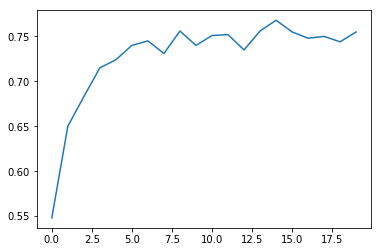

In [13]:
plt.plot(accuracies)

## Part 2: Embedding Lookup layer

![](./img/embedding.png)

###  Define an embedding layer

It's not hard to imagine in the previous practices, the input we fed in are very sparse because each word was represented as a one-hot vector. This makes it difficult for the network to understand what story the input data is telling. 

Word embedding: instead of using a one-hot vector to represent each word, we can add an word embedding matrix in which each word is represented as a low-dimensional vector. Note that this representation is not sparse any more, because we're working in a continuous vector space now. Words that share similar/related semantic meaning should be 'close to each other' in this vector space (we could define a distance measure to estimate the closeness). 

[https://www.tensorflow.org/tutorials/word2vec](https://www.tensorflow.org/tutorials/word2vec)

<span style="color:red">__TODO:__</span> Take a look at the website above, and write a function to do the embedding. The website itself is a very good tutorial.

Hint: Use **tf.nn.embedding_lookup**

In [14]:
def embedding(input_, vocab_size, output_size, name):
    """
    1. Define an embedding matrix
    2. return both the lookup results and the embedding matrix.
    """
    
    embeddings = tf.Variable(tf.random_uniform([vocab_size, output_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, input_)
    
    return embeddings,embed
    
    

#     pass
# YOUR CODE HERE

### Train a single lstm network with embedding layer

<span style="color:red">__TODO:__</span> Build a single-layer LSTM network according to the network structure. Then, train the network with the training function you wrote.

In [42]:
# YOUR EMBEDDING SINGLE-LAYER LSTM HERE

# set variables
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64
output_size = 500

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

lookup, train_tweets_embeddings = embedding(tweets,vocab_size,output_size,'embeddings')

# tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
# init_state = lstm_cell.zero_state(batch_size, tf.float32)
init_state=None
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, train_tweets_embeddings, initial_state=init_state, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
# print(sentiment)
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

In [43]:
# YOUR TRAINING HERE

# Training function
num_steps = 1000
accuracies=[]
numBatches=int(train_tweets.shape[0]/batch_size)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        # TODO: get data for a batch
        
        lowInd= (step % numBatches) * batch_size
        highInd=lowInd + batch_size

        batch_tweets = train_tweets[lowInd : highInd]
#         print(batch_tweets.shape)
        batch_labels = train_labels[lowInd : highInd]

        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer, loss, acc], feed_dict={tweets: batch_tweets, 
                                                                               labels: batch_labels})
        
        print('{}/{} loss: {}'.format(
                    batch_size * (step + 1),
                    train_tweets.shape[0],
                    train_loss))
#         print(train_acc)
        
#         _, train_loss, train_acc = pass

        if (step % 50 == 0):
            accuracy=sess.run([acc], feed_dict={tweets: test_tweets, labels: test_labels})
            print('test accuracy - ', accuracy)
#             TODO: get test accuracy and loss, and print them out.
            accuracies.append(accuracy)
    vocab_embeddings = sess.run(lookup)
            

64/60000 loss: 0.710961103439331
test accuracy -  [0.52200001]
128/60000 loss: 0.8358703851699829
192/60000 loss: 0.7517783641815186
256/60000 loss: 0.6847838163375854
320/60000 loss: 0.7140894532203674
384/60000 loss: 0.742595911026001
448/60000 loss: 0.6900437474250793
512/60000 loss: 0.6980141401290894
576/60000 loss: 0.7181396484375
640/60000 loss: 0.6951382756233215
704/60000 loss: 0.7151532173156738
768/60000 loss: 0.6788274645805359
832/60000 loss: 0.7253153324127197
896/60000 loss: 0.6973816156387329
960/60000 loss: 0.7214869260787964
1024/60000 loss: 0.694501519203186
1088/60000 loss: 0.6809520721435547
1152/60000 loss: 0.7020710110664368
1216/60000 loss: 0.6919604539871216
1280/60000 loss: 0.7047496438026428
1344/60000 loss: 0.6821397542953491
1408/60000 loss: 0.686265230178833
1472/60000 loss: 0.6902551651000977
1536/60000 loss: 0.6891756057739258
1600/60000 loss: 0.6958894729614258
1664/60000 loss: 0.6995309591293335
1728/60000 loss: 0.6984542608261108
1792/60000 loss: 0.67

14528/60000 loss: 0.5070432424545288
14592/60000 loss: 0.5496864318847656
14656/60000 loss: 0.4915255308151245
14720/60000 loss: 0.5607842803001404
14784/60000 loss: 0.5983952283859253
14848/60000 loss: 0.5059982538223267
14912/60000 loss: 0.5616447925567627
14976/60000 loss: 0.6006761789321899
15040/60000 loss: 0.5752526521682739
15104/60000 loss: 0.5799274444580078
15168/60000 loss: 0.551139771938324
15232/60000 loss: 0.4527902901172638
15296/60000 loss: 0.5048819780349731
15360/60000 loss: 0.6306161284446716
15424/60000 loss: 0.4835885167121887
15488/60000 loss: 0.5094883441925049
15552/60000 loss: 0.5400156378746033
15616/60000 loss: 0.5209801197052002
15680/60000 loss: 0.6237703561782837
15744/60000 loss: 0.5369399189949036
15808/60000 loss: 0.48516321182250977
15872/60000 loss: 0.5359504222869873
15936/60000 loss: 0.6145642995834351
16000/60000 loss: 0.5224173069000244
16064/60000 loss: 0.45698636770248413
test accuracy -  [0.72300005]
16128/60000 loss: 0.6078375577926636
16192/6

29248/60000 loss: 0.513005256652832
29312/60000 loss: 0.4872218668460846
29376/60000 loss: 0.6088027358055115
29440/60000 loss: 0.5512770414352417
29504/60000 loss: 0.4010933041572571
29568/60000 loss: 0.5646759867668152
29632/60000 loss: 0.6389539241790771
29696/60000 loss: 0.584815263748169
29760/60000 loss: 0.5919809341430664
29824/60000 loss: 0.5620327591896057
29888/60000 loss: 0.5268814563751221
29952/60000 loss: 0.6082935333251953
30016/60000 loss: 0.4813096523284912
30080/60000 loss: 0.5016820430755615
30144/60000 loss: 0.5121356248855591
30208/60000 loss: 0.5307782292366028
30272/60000 loss: 0.43200045824050903
30336/60000 loss: 0.45160529017448425
30400/60000 loss: 0.5171264410018921
30464/60000 loss: 0.5118163228034973
30528/60000 loss: 0.466230183839798
30592/60000 loss: 0.5253725051879883
30656/60000 loss: 0.4969269335269928
30720/60000 loss: 0.516093373298645
30784/60000 loss: 0.5084973573684692
30848/60000 loss: 0.5451315641403198
30912/60000 loss: 0.4780488610267639
309

43968/60000 loss: 0.522447943687439
44032/60000 loss: 0.5874486565589905
44096/60000 loss: 0.47454357147216797
44160/60000 loss: 0.43609482049942017
44224/60000 loss: 0.5576180219650269
44288/60000 loss: 0.5481005907058716
44352/60000 loss: 0.49234169721603394
44416/60000 loss: 0.39794692397117615
44480/60000 loss: 0.4908343553543091
44544/60000 loss: 0.4658345580101013
44608/60000 loss: 0.5909802913665771
44672/60000 loss: 0.5081912875175476
44736/60000 loss: 0.492819607257843
44800/60000 loss: 0.5668704509735107
44864/60000 loss: 0.5092096924781799
test accuracy -  [0.75299996]
44928/60000 loss: 0.5101338028907776
44992/60000 loss: 0.42504167556762695
45056/60000 loss: 0.4896509647369385
45120/60000 loss: 0.5499444007873535
45184/60000 loss: 0.4008413553237915
45248/60000 loss: 0.45607173442840576
45312/60000 loss: 0.5016947984695435
45376/60000 loss: 0.45896732807159424
45440/60000 loss: 0.5665324926376343
45504/60000 loss: 0.47047269344329834
45568/60000 loss: 0.5582326650619507
45

58624/60000 loss: 0.4699363708496094
58688/60000 loss: 0.5274201035499573
58752/60000 loss: 0.33367154002189636
58816/60000 loss: 0.5328829884529114
58880/60000 loss: 0.59138023853302
58944/60000 loss: 0.3433958888053894
59008/60000 loss: 0.5028654932975769
59072/60000 loss: 0.5037093758583069
59136/60000 loss: 0.5080406665802002
59200/60000 loss: 0.43662962317466736
59264/60000 loss: 0.49961555004119873
59328/60000 loss: 0.5382685661315918
59392/60000 loss: 0.5076045989990234
59456/60000 loss: 0.47564899921417236
59520/60000 loss: 0.44336172938346863
59584/60000 loss: 0.5115371942520142
59648/60000 loss: 0.4224467873573303
59712/60000 loss: 0.4630192816257477
59776/60000 loss: 0.5134143829345703
59840/60000 loss: 0.42286235094070435
59904/60000 loss: 0.47980499267578125
59968/60000 loss: 0.4432375431060791
60032/60000 loss: 0.4581695795059204
60096/60000 loss: 0.4273061752319336
60160/60000 loss: 0.48907700181007385
60224/60000 loss: 0.53815758228302
60288/60000 loss: 0.45773282647132

### Visualize word vectors via tSNE

<span style="color:red">__TODO:__</span>

First, you need to retrieve **embedding matrix** from the network. Then use tSNE to reduce each low-dimensional word vector into a 2D vector. 

And then, you should visualize some interesting word pairs in 2D panel. You may find **scatter** function in **matplotlib.pyplot** useful.


Hint: You can use **TSNE** tool provided in **scikit-learn**. And if you encounter dead kernel problem caused by "Intel MKL FATAL ERROR: Cannot load libmkl_avx.so or libmkl_def.so", please reinstall scikit-learn without MKL, ie., **conda install nomkl numpy scipy scikit-learn numexpr**. 

Here we provide some word pairs for you, like female-male or country-capital. And you can observe that these word-pair will look parallel with each other in a 2D tSNE panel. And you can find some other words and explore their relationship.

The result for female-male pairs should look like, and you will observe that king-men and queen-women are parallel to each other in a 2D panel.


![](./img/tsne_female_male.png)

In [44]:
vocab_embeddings.shape

(7597, 500)

In [45]:
reverse_dict={word:i for i, word in enumerate(vocabulary)}

In [52]:
female_male = ["men", "women", "king", "queen"]
country_capital = ["spain", "madrid", "italy", "rome", "japan", "tokyo"]
# you can try some other words

In [53]:
female_male_indices=[reverse_dict[w] for w in female_male]
country_capital_indices=[reverse_dict[w] for w in country_capital]

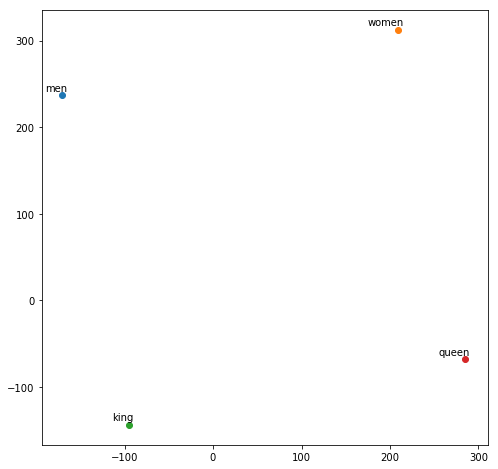

In [51]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
low_dim_emb_maleFemale = tsne.fit_transform(vocab_embeddings[female_male_indices])
labels = [vocabulary[i] for i in female_male_indices]
plt.figure(figsize=(8, 8))  # in inches
for i, label in enumerate(labels):
    x, y = low_dim_emb_maleFemale[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

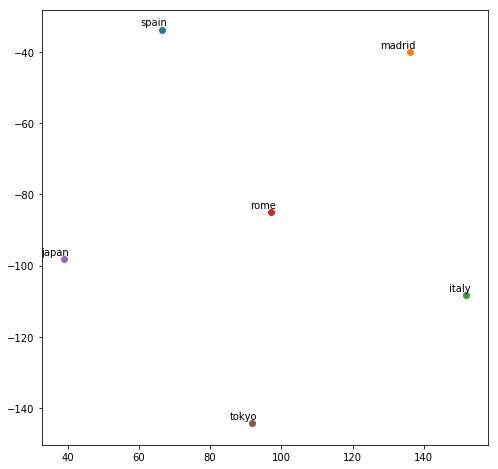

In [54]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
low_dim_emb_countryCapital = tsne.fit_transform(vocab_embeddings[country_capital_indices])
labels = [vocabulary[i] for i in country_capital_indices]
plt.figure(figsize=(8, 8))  # in inches
for i, label in enumerate(labels):
    x, y = low_dim_emb_countryCapital[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')


#### <span style="color:red">TODO: </span> describe your observation of these word vectors

Answer: **As we can see from the above plots, similar words occur close to each other in the embedding space. Also if we draw analogies between two pair of words, we find that the lines between the pair of the words is parallel to each other. For example - line joining women-queen is parallel to line joining men-king, and line joining countries to their capitals are also parallel to each other **